In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import random

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

**System details**

In [3]:
import sys
import sklearn

print("Scikit-learn:", sklearn.__version__)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Scikit-learn: 1.4.2
Pandas: 2.2.3
NumPy: 1.26.4


In [4]:
random.seed(2025) #For reproducibility
np.random.seed(2025)

In [5]:
df = pd.read_parquet('CiC_IoT23_clean.parquet')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24570795 entries, 0 to 46686577
Data columns (total 45 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float32
 1   Header_Length    uint32 
 2   Protocol Type    uint16 
 3   Duration         float32
 4   Rate             float64
 5   Drate            float32
 6   fin_flag_number  bool   
 7   syn_flag_number  bool   
 8   rst_flag_number  bool   
 9   psh_flag_number  bool   
 10  ack_flag_number  bool   
 11  ece_flag_number  bool   
 12  cwr_flag_number  bool   
 13  ack_count        float16
 14  syn_count        float16
 15  fin_count        float32
 16  urg_count        float32
 17  rst_count        uint16 
 18  HTTP             bool   
 19  HTTPS            bool   
 20  DNS              bool   
 21  Telnet           bool   
 22  SMTP             bool   
 23  SSH              bool   
 24  IRC              bool   
 25  TCP              bool   
 26  UDP              bool   
 27  DHCP           

In [7]:
print(df['label'].value_counts())

label
DDoS-UDP_Flood             5412287
DDoS-SynonymousIP_Flood    2881222
DoS-UDP_Flood              2827054
DoS-TCP_Flood              1609099
DoS-SYN_Flood              1477041
DDoS-SYN_Flood             1358884
DDoS-PSHACK_Flood          1147808
DDoS-ICMP_Flood            1130525
BenignTraffic              1098177
DDoS-TCP_Flood             1050003
Mirai-udpplain              890576
DDoS-RSTFINFlood            706875
Mirai-greeth_flood          542672
Mirai-greip_flood           463420
DDoS-ICMP_Fragmentation     425702
MITM-ArpSpoofing            307590
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      260481
DNS_Spoofing                178849
Recon-HostDiscovery         134270
Recon-OSScan                 98012
Recon-PortScan               82013
DoS-HTTP_Flood               71642
VulnerabilityScan            37382
DDoS-HTTP_Flood              28711
DDoS-SlowLoris               23426
DictionaryBruteForce         13064
BrowserHijacking              5859
CommandInjecti

In [8]:
# Creating a dictionary of attack types for 33 attack classes + 1 for benign traffic
attacks = {'BenignTraffic': 0 ,
                    'DDoS-RSTFINFlood' :1, 'DDoS-PSHACK_Flood':2,  'DDoS-SYN_Flood':3, 'DDoS-UDP_Flood':4, 'DDoS-TCP_Flood':5, 
                    'DDoS-ICMP_Flood':6, 'DDoS-SynonymousIP_Flood':7, 'DDoS-ACK_Fragmentation':8, 'DDoS-UDP_Fragmentation':9, 'DDoS-ICMP_Fragmentation':10, 
                    'DDoS-SlowLoris':11, 'DDoS-HTTP_Flood':12, 'DoS-UDP_Flood':13, 'DoS-SYN_Flood':14, 'DoS-TCP_Flood':15, 'DoS-HTTP_Flood':16,                 # DDoS and DoS
                    'Mirai-greeth_flood': 17, 'Mirai-greip_flood': 18, 'Mirai-udpplain': 19,                                                                    # Mirai 
                    'Recon-PingSweep': 20, 'Recon-OSScan': 21, 'Recon-PortScan': 22, 'VulnerabilityScan': 23, 'Recon-HostDiscovery': 24,                        # Reconnaissance
                    'DNS_Spoofing': 25, 'MITM-ArpSpoofing': 26,                                                                                                 # Spoofing
                    'BrowserHijacking': 27, 'Backdoor_Malware': 28, 'XSS': 29, 'Uploading_Attack': 30, 'SqlInjection': 31, 'CommandInjection': 32,              # Web
                    'DictionaryBruteForce': 33}
df['label'] = df['label'].map(attacks)

In [9]:
X = df.drop(columns=['label'])
y = df['label']

In [10]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Save test data for Raspberry Pi
np.save("RaspberryPi/X_test.npy", X_test.astype(np.float32))
np.save("RaspberryPi/y_test.npy", y_test.astype(np.float32))
np.save("RaspberryPi/feature_names_base.npy", X_test.columns.to_numpy())

In [12]:
# Undersampling majority classes
df_train = X_train.copy()
df_train['label'] = y_train

# Contador por clase
label_counts = df_train['label'].value_counts()

# Lista para almacenar los subsets
sampled_dfs = []

for label, count in label_counts.items():
    class_subset = df_train[df_train['label'] == label]
    
    if count < 100_000:
        sampled = class_subset  # conservar todo
    elif count < 500_000:
        sampled = class_subset.sample(frac=0.6, random_state=42)
    elif count < 5_000_000:
        sampled = class_subset.sample(frac=0.4, random_state=42)        
    else:
        sampled = class_subset.sample(frac=0.2, random_state=42)
    
    sampled_dfs.append(sampled)

# Unir todos los subconjuntos
df_train_sampled = pd.concat(sampled_dfs, ignore_index=True)

# Separar nuevamente X_train e y_train
X_train = df_train_sampled.drop(columns='label')
y_train = df_train_sampled['label']

# Mostrar la nueva distribución
print("Final distribution on training set:\n")
print(y_train.value_counts())

Final distribution on training set:

label
4     1731932
7      921991
13     904657
15     514912
14     472653
3      434843
2      367298
6      361768
0      351416
5      336001
19     284984
17     260483
1      226200
18     222442
10     204337
26     147643
9      137724
8      125031
25      85847
21      78410
22      65610
24      64450
16      57314
23      29906
12      22969
11      18741
33      10451
27       4687
32       4327
31       4196
29       3077
28       2574
20       1805
30       1002
Name: count, dtype: int64


**Random Forest base**

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train base Random Forest
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
start_train = time.time()
rf_model.fit(X_train, y_train)
train_time_base = time.time() - start_train

num_repetitions = 10    
inference_times = []
for _ in range(num_repetitions):
    start_pred = time.time()
    y_pred = rf_model.predict(X_test)
    inference_times.append(time.time() - start_pred)

# Compute median inference time
inference_time_base = np.median(inference_times)

# Compute test accuracy
test_accuracy_base = rf_model.score(X_test, y_test)

# Save model and check model size
model_filename = os.path.join("RaspberryPi", "base_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)
model_size_base = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB    

print(f" RF base model")
print(f" Test accuracy: {test_accuracy_base:.4f}\n")
print(f" Training time: {train_time_base:.4f}\n")
print(f" Inference time: {inference_time_base:.4f}\n")
print(f" Model Size: {model_size_base:.4f}\n")

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))


 RF base model
 Test accuracy: 0.9906

 Training time: 93.5113

 Inference time: 11.9568

 Model Size: 1750.6262

              precision    recall  f1-score   support

           0     0.9244    0.9699    0.9466    219636
           1     0.9995    0.9977    0.9986    141375
           2     0.9996    0.9989    0.9993    229562
           3     0.9987    0.9985    0.9986    271777
           4     0.9995    0.9997    0.9996   1082458
           5     0.9988    0.9984    0.9986    210001
           6     0.9992    0.9986    0.9989    226105
           7     0.9998    0.9996    0.9997    576244
           8     0.9946    0.9970    0.9958     52096
           9     0.9972    0.9985    0.9978     57385
          10     0.9966    0.9989    0.9977     85140
          11     0.9747    0.9955    0.9850      4685
          12     0.9918    0.9901    0.9909      5742
          13     0.9996    0.9993    0.9994    565411
          14     0.9993    0.9995    0.9994    295408
          15     0.99

**Feature selection methods: Chi2, Mutual Information, RF permutation importance** 

**Chi2**

In [14]:
# Apply the Chi-Squared test
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X_train, y_train)

In [15]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

chi_scores_series = pd.Series(chi_scores, index=X.columns).sort_values(ascending=False)
chi_scores_series = chi_scores_series.fillna(0)

print("Ranking of features according to Chi2 test")
pd.options.display.max_rows = None  # Mostrar todas las filas sin truncar
print(chi_scores_series)

Ranking of features according to Chi2 test
Header_Length      9.682451e+12
Tot sum            3.090213e+10
rst_count          8.213305e+09
Max                6.708890e+09
Radius             4.396938e+09
IAT                4.018511e+09
Std                3.110391e+09
Tot size           2.947303e+09
AVG                2.946508e+09
Min                1.343137e+09
Protocol Type      6.695367e+07
Magnitude          5.454031e+07
Covariance         3.315346e+07
urg_count          2.377009e+07
Rate               1.853995e+07
Duration           1.831325e+07
flow_duration      1.002623e+07
fin_flag_number    8.155063e+06
ICMP               7.727893e+06
psh_flag_number    6.862632e+06
syn_flag_number    6.315289e+06
rst_flag_number    6.108902e+06
ack_flag_number    5.425639e+06
UDP                5.079268e+06
syn_count          5.070869e+06
ack_count          4.186510e+06
TCP                4.001635e+06
Variance           3.497104e+06
HTTPS              2.968129e+06
fin_count          1.463832e+

**Mutual information**

In [16]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=42)


In [17]:
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

print("Ranking of features according to MI")
pd.options.display.max_rows = None  
print(mutual_info_series)


Ranking of features according to MI
IAT                2.714421
Tot size           1.608321
Magnitude          1.559458
AVG                1.535426
Tot sum            1.531271
Max                1.498975
Min                1.495068
Header_Length      1.354038
Protocol Type      1.223706
Std                0.867316
Radius             0.855359
Covariance         0.852890
Rate               0.820136
syn_count          0.760444
flow_duration      0.753798
TCP                0.735085
UDP                0.646464
Variance           0.641574
syn_flag_number    0.557445
Duration           0.515110
Weight             0.496629
Number             0.445398
rst_count          0.368418
urg_count          0.321088
ack_flag_number    0.298790
ICMP               0.255518
ack_count          0.218165
psh_flag_number    0.168560
IPv                0.131997
fin_flag_number    0.127925
rst_flag_number    0.125137
HTTPS              0.121493
HTTP               0.050162
fin_count          0.025652
SSH         

**RF Permutation Importance**

In [18]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1
)

In [19]:
feature_importances_permutation = pd.Series(perm_importance.importances_mean, index = X_test.columns).sort_values(ascending=False)
print("Ranking of features according to Permutation Importance")
pd.options.display.max_rows = None  
print(feature_importances_permutation)


Ranking of features according to Permutation Importance
IAT                4.255761e-01
syn_flag_number    8.846999e-02
fin_flag_number    2.188142e-02
urg_count          1.140106e-02
syn_count          1.028797e-02
rst_count          9.001683e-03
flow_duration      5.812571e-03
Header_Length      3.579005e-03
Rate               2.626024e-03
Protocol Type      2.605410e-03
Duration           1.796645e-03
HTTPS              1.795506e-03
rst_flag_number    1.389800e-03
Number             1.328427e-03
Variance           9.839323e-04
AVG                9.014157e-04
Tot size           8.747784e-04
Weight             6.527261e-04
ack_flag_number    6.427142e-04
Magnitude          6.160769e-04
Tot sum            5.988410e-04
Max                5.746049e-04
ICMP               4.298192e-04
Radius             4.185864e-04
Covariance         3.878588e-04
HTTP               3.652914e-04
Min                3.477502e-04
Std                3.358662e-04
TCP                3.105516e-04
UDP             

In [20]:
importance_perm_ranking = feature_importances_permutation.rank(ascending=False).astype(int)
mutual_info_ranking = mutual_info_series.rank(ascending=False).astype(int)
chi2_ranking = chi_scores_series.rank(ascending=False).astype(int)

In [21]:
ranking_table = pd.DataFrame({'Imp. Permutation': importance_perm_ranking, 'Mutual Information': mutual_info_ranking, 'Chi2': chi2_ranking})
ranking_table = ranking_table.sort_values(by='Imp. Permutation')
print("Feature ranking table")
display(ranking_table)

Feature ranking table


,Imp. Permutation,Mutual Information,Chi2
IAT,1,1,6
syn_flag_number,2,19,21
fin_flag_number,3,30,18
urg_count,4,24,14
syn_count,5,14,25
rst_count,6,23,3
flow_duration,7,15,17
Header_Length,8,8,1
Rate,9,13,15
Protocol Type,10,9,11


### Convergence Analysis

**Chi2**

In [22]:
top_features = chi_scores_series.index[:41]

results_Chi = []

# Main loop
for i in range(1, 41):  
    selected_subset = top_features[:i] 
    
    X_train_subset = X_train[selected_subset]
    X_test_subset = X_test[selected_subset]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    start_train = time.time()
    rf_model.fit(X_train_subset, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_subset)
        inference_times.append(time.time() - start_pred)

    # Inference time
    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_subset, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)    

    # Save results
    results_Chi.append({
        "Num features": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })
    
    # Print progress
    print(f" Model with {i} features: {list(selected_subset)}")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f}\n")
    print(f" Inference time: {inference_time_median:.4f}\n")
    print(f" Model size: {model_size:.4f}\n")    

 Model with 1 features: ['Header_Length']
 Test accuracy: 0.5000

 Training time: 92.9583

 Inference time: 15.5781

 Model size: 5466.5651

 Model with 2 features: ['Header_Length', 'Tot sum']
 Test accuracy: 0.6244

 Training time: 126.0122

 Inference time: 21.4821

 Model size: 13513.5930

 Model with 3 features: ['Header_Length', 'Tot sum', 'rst_count']
 Test accuracy: 0.6701

 Training time: 125.8323

 Inference time: 20.1852

 Model size: 12115.5658

 Model with 4 features: ['Header_Length', 'Tot sum', 'rst_count', 'Max']
 Test accuracy: 0.6909

 Training time: 134.1918

 Inference time: 20.7317

 Model size: 10871.5517

 Model with 5 features: ['Header_Length', 'Tot sum', 'rst_count', 'Max', 'Radius']
 Test accuracy: 0.6969

 Training time: 142.8539

 Inference time: 19.4755

 Model size: 11089.3440

 Model with 6 features: ['Header_Length', 'Tot sum', 'rst_count', 'Max', 'Radius', 'IAT']
 Test accuracy: 0.9874

 Training time: 45.0734

 Inference time: 9.9122

 Model size: 167

**Mutual_info**

In [23]:
top_features = mutual_info_series.index[:41]

results_MI = []

# Main loop
for i in range(1, 41):  
    selected_subset = top_features[:i]  
    
    X_train_subset = X_train[selected_subset]
    X_test_subset = X_test[selected_subset]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    start_train = time.time()
    rf_model.fit(X_train_subset, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_subset)
        inference_times.append(time.time() - start_pred)

    # Inference time
    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_subset, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB       

    # Save reuslts
    results_MI.append({
        "Num features": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })

    # Print progress    
    print(f" Model with {i} features: {list(selected_subset)}")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f}\n")
    print(f" Inference time: {inference_time_median:.4f}\n")
    print(f" Model size: {model_size:.4f}\n")    

 Model with 1 features: ['IAT']
 Test accuracy: 0.9782

 Training time: 24.9753

 Inference time: 8.3988

 Model size: 896.3959

 Model with 2 features: ['IAT', 'Tot size']
 Test accuracy: 0.9809

 Training time: 27.1995

 Inference time: 9.2301

 Model size: 2029.4244

 Model with 3 features: ['IAT', 'Tot size', 'Magnitude']
 Test accuracy: 0.9836

 Training time: 31.3164

 Inference time: 8.9318

 Model size: 2220.4860

 Model with 4 features: ['IAT', 'Tot size', 'Magnitude', 'AVG']
 Test accuracy: 0.9839

 Training time: 52.8364

 Inference time: 8.9274

 Model size: 1736.0435

 Model with 5 features: ['IAT', 'Tot size', 'Magnitude', 'AVG', 'Tot sum']
 Test accuracy: 0.9842

 Training time: 48.8220

 Inference time: 9.1367

 Model size: 1797.3714

 Model with 6 features: ['IAT', 'Tot size', 'Magnitude', 'AVG', 'Tot sum', 'Max']
 Test accuracy: 0.9851

 Training time: 47.1699

 Inference time: 9.1567

 Model size: 1834.0259

 Model with 7 features: ['IAT', 'Tot size', 'Magnitude', 'A

**RF Importance permutacion**

In [24]:
top_features = feature_importances_permutation.index[:41]

results_RF = []

# Main loop
for i in range(1, 41): 
    selected_subset = top_features[:i]  
    
    X_train_subset = X_train[selected_subset]
    X_test_subset = X_test[selected_subset]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    start_train = time.time()
    rf_model.fit(X_train_subset, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_subset)
        inference_times.append(time.time() - start_pred)

    # Inference time
    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_subset, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB       

    # Save results
    results_RF.append({
        "Num features": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })
    
    # Print progress
    print(f" Model with {i} features: {list(selected_subset)}")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f}\n")
    print(f" Inference_time: {inference_time_median:.4f}\n")
    print(f" Model Size: {model_size:.4f}\n")    

 Model with 1 features: ['IAT']
 Test accuracy: 0.9782

 Training time: 23.4894

 Inference_time: 8.0992

 Model Size: 896.3959

 Model with 2 features: ['IAT', 'syn_flag_number']
 Test accuracy: 0.9792

 Training time: 21.9736

 Inference_time: 8.3347

 Model Size: 943.6703

 Model with 3 features: ['IAT', 'syn_flag_number', 'fin_flag_number']
 Test accuracy: 0.9793

 Training time: 22.0630

 Inference_time: 8.2650

 Model Size: 944.2323

 Model with 4 features: ['IAT', 'syn_flag_number', 'fin_flag_number', 'urg_count']
 Test accuracy: 0.9799

 Training time: 23.0241

 Inference_time: 8.6283

 Model Size: 1899.8906

 Model with 5 features: ['IAT', 'syn_flag_number', 'fin_flag_number', 'urg_count', 'syn_count']
 Test accuracy: 0.9819

 Training time: 23.1429

 Inference_time: 8.3781

 Model Size: 1937.4667

 Model with 6 features: ['IAT', 'syn_flag_number', 'fin_flag_number', 'urg_count', 'syn_count', 'rst_count']
 Test accuracy: 0.9861

 Training time: 23.3303

 Inference_time: 8.5518

**PCA**

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalise data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute PCA
pca = PCA(n_components=None)
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)


In [39]:
results_PCA = []

# Main loop
for i in range(3, 41):  
    X_train_pca = X_train_pca_full[:, :i] 
    X_test_pca = X_test_pca_full[:, :i]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    
    start_train = time.time()
    rf_model.fit(X_train_pca, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_pca)
        inference_times.append(time.time() - start_pred)

    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_pca, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB       

    # Save results
    results_PCA.append({
        "Num components": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })

    # Print progress
    print(f" Model with {i} principal components")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f} s\n")
    print(f" Inference time: {inference_time_median:.4f} s\n")
    print(f" Model size: {model_size:.4f} MB\n")

 Model with 3 principal components
 Test accuracy: 0.8775

 Training time: 101.4779 s

 Inference time: 19.8956 s

 Model size: 11562.8526 MB

 Model with 4 principal components
 Test accuracy: 0.9045

 Training time: 179.2941 s

 Inference time: 19.4438 s

 Model size: 8036.9771 MB

 Model with 5 principal components
 Test accuracy: 0.9137

 Training time: 204.3491 s

 Inference time: 20.8113 s

 Model size: 7508.7567 MB

 Model with 6 principal components
 Test accuracy: 0.9220

 Training time: 184.3944 s

 Inference time: 19.1839 s

 Model size: 7065.5002 MB

 Model with 7 principal components
 Test accuracy: 0.9237

 Training time: 194.2322 s

 Inference time: 19.8192 s

 Model size: 6948.2295 MB

 Model with 8 principal components
 Test accuracy: 0.9255

 Training time: 214.6406 s

 Inference time: 20.7870 s

 Model size: 6868.5528 MB

 Model with 9 principal components
 Test accuracy: 0.9270

 Training time: 318.9535 s

 Inference time: 18.5906 s

 Model size: 6206.6247 MB

 Mode

In [27]:
# Extract data

num_features_Chi = [result["Num features"] for result in results_Chi]
accuracies_Chi = [result["Accuracy"] for result in results_Chi]
train_time_Chi = [result["Training time (s)"] for result in results_Chi]
test_time_Chi = [result["Inference time (s)"] for result in results_Chi]
model_size_Chi = [result["Model size (MB)"] for result in results_Chi]

num_features_MI = [result["Num features"] for result in results_MI]
accuracies_MI = [result["Accuracy"] for result in results_MI]
train_time_MI = [result["Training time (s)"] for result in results_MI]
test_time_MI = [result["Inference time (s)"] for result in results_MI]
model_size_MI = [result["Model size (MB)"] for result in results_MI]

num_features_RF = [result["Num features"] for result in results_RF]
accuracies_RF = [result["Accuracy"] for result in results_RF]
train_time_RF = [result["Training time (s)"] for result in results_RF]
test_time_RF = [result["Inference time (s)"] for result in results_RF]
model_size_RF = [result["Model size (MB)"] for result in results_RF]


In [40]:
num_components_PCA = [result["Num components"] for result in results_PCA]
accuracies_PCA = [result["Accuracy"] for result in results_PCA]
train_time_PCA = [result["Training time (s)"] for result in results_PCA]
test_time_PCA = [result["Inference time (s)"] for result in results_PCA]
model_size_PCA = [result["Model size (MB)"] for result in results_PCA]

In [28]:
#Cleaning unnecessary files
os.remove("RandomForest.pkl")

**Plots**

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

mpl.rcParams.update({
    "text.usetex": False,            
    "font.family": "serif",           
    "font.serif": ["DejaVu Serif"],    
    "mathtext.fontset": "cm",          
    "mathtext.rm": "serif",            
    "axes.unicode_minus": False        
})

Accuracy plot

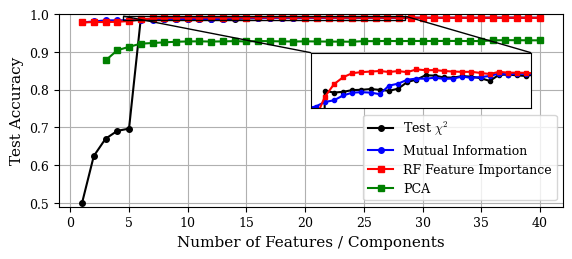

In [92]:
fig, ax = plt.subplots(figsize=(6.5, 2.5)) 

#Main plot
ax.plot(num_features_Chi, accuracies_Chi, marker='o', linestyle='-', color='k', markersize=4, label=r"Test $\chi^2$")
ax.plot(num_features_MI, accuracies_MI, marker='o', linestyle='-', color='b', markersize=4, label="Mutual Information")
ax.plot(num_features_RF, accuracies_RF, marker='s', linestyle='-', color='r', markersize=4, label="RF Feature Importance")
ax.plot(num_components_PCA, accuracies_PCA, marker='s', linestyle='-', color='g', markersize=4, label="PCA")

ax.set_xlabel("Number of Features / Components", fontsize=11)
ax.set_ylabel("Test Accuracy", fontsize=11)
ax.tick_params(axis='both', labelsize=9)
ax.legend(fontsize=9)
ax.grid(True)
ax.set_ylim(0.49, 1)


#Zoom plot
axins = inset_axes(
    ax,
    width=2.2, height=0.55,  
    loc='upper left',
    bbox_to_anchor=(0.5, 0.80),  #Position
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(num_features_Chi, accuracies_Chi, marker='o', linestyle='-', color='k', markersize=3)
axins.plot(num_features_MI, accuracies_MI, marker='o', linestyle='-', color='b', markersize=3)
axins.plot(num_features_RF, accuracies_RF, marker='s', linestyle='-', color='r', markersize=3)
axins.plot(num_components_PCA, accuracies_PCA, marker='s', linestyle='-', color='g', markersize=3)

axins.set_xticks([])
axins.set_yticks([])

axins.set_xlim(4.5, 28.5)
axins.set_ylim(0.984, 0.995)
axins.grid(True)

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="black",zorder=10)

plt.show()
plt.savefig("accuracy_vs_features.png", dpi=300)
fig.savefig("accuracy_vs_features.pdf", bbox_inches='tight')
plt.close()



Model size plot

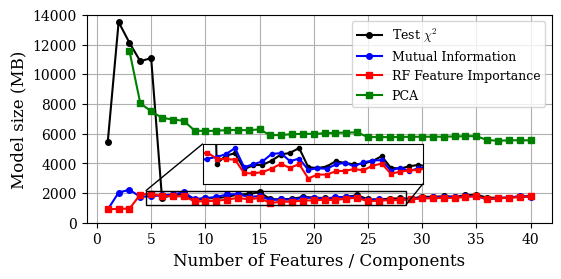

In [93]:
fig, ax = plt.subplots(figsize=(6, 2.7)) 

#Main plot
plt.plot(num_features_Chi, model_size_Chi, marker='o', linestyle='-', color='k', markersize=4, label=r"Test $\chi^2$")
plt.plot(num_features_MI, model_size_MI, marker='o', linestyle='-', color='b', markersize=4, label="Mutual Information")
plt.plot(num_features_RF, model_size_RF, marker='s', linestyle='-', color='r', markersize=4, label="RF Feature Importance")
plt.plot(num_components_PCA, model_size_PCA, marker='s', linestyle='-', color='g', markersize=4, label="PCA")

ax.set_xlabel("Number of Features / Components", fontsize=12)
ax.set_ylabel("Model size (MB)", fontsize=12)
ax.set_ylim(0, 14000)


ax.legend(fontsize=9)
ax.grid(True)


#Zoom plot
axins = inset_axes(
    ax,
    width=2.2, height=0.40,  
    loc='upper left',
    bbox_to_anchor=(0.25, 0.38),  #Position
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(num_features_Chi, model_size_Chi, marker='o', linestyle='-', color='k', markersize=3)
axins.plot(num_features_MI, model_size_MI, marker='o', linestyle='-', color='b', markersize=3)
axins.plot(num_features_RF, model_size_RF, marker='s', linestyle='-', color='r', markersize=3)
axins.plot(num_components_PCA, model_size_PCA, marker='s', linestyle='-', color='g', markersize=3)

axins.set_xticks([])
axins.set_yticks([])

axins.set_xlim(4.5, 28.5)
axins.set_ylim(1200, 2150)
axins.grid(True)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black",zorder=10)

plt.show()
plt.savefig("Size_vs_features.png", dpi=300)
fig.savefig("Size_vs_features.pdf", bbox_inches='tight')
plt.close()


Inference time plot

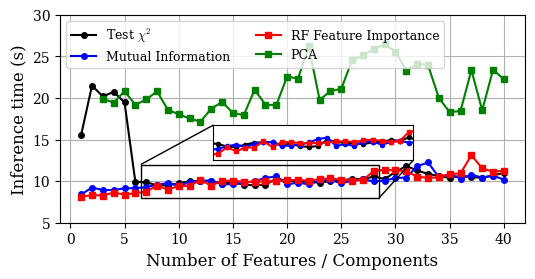

In [94]:
fig, ax = plt.subplots(figsize=(6, 2.7)) 

plt.plot(num_features_Chi, test_time_Chi, marker='o', linestyle='-', color='k', markersize=4, label=r"Test $\chi^2$")
plt.plot(num_features_MI, test_time_MI, marker='o', linestyle='-', color='b', markersize=4, label="Mutual Information")
plt.plot(num_features_RF, test_time_RF, marker='s', linestyle='-', color='r', markersize=4, label="RF Feature Importance")
plt.plot(num_components_PCA, test_time_PCA, marker='s', linestyle='-', color='g', markersize=4, label="PCA")

ax.set_xlabel("Number of Features / Components", fontsize=12)
ax.set_ylabel("Inference time (s)", fontsize=12)
ax.set_ylim(5, 30)

ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True)

#Zoom plot
axins = inset_axes(
    ax,
    width=2.0, height=0.35,  
    loc='upper left',
    bbox_to_anchor=(0.33, 0.47),  #Position
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(num_features_Chi, test_time_Chi, marker='o', linestyle='-', color='k', markersize=3)
axins.plot(num_features_MI, test_time_MI, marker='o', linestyle='-', color='b', markersize=3)
axins.plot(num_features_RF, test_time_RF, marker='s', linestyle='-', color='r', markersize=3)
axins.plot(num_components_PCA, test_time_PCA, marker='s', linestyle='-', color='g', markersize=3)

axins.set_xticks([])
axins.set_yticks([])

axins.set_xlim(6.5, 28.5)
axins.set_ylim(8, 12)
axins.grid(True)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black",zorder=10)


plt.show()
plt.savefig("Time_vs_features.png", dpi=300)
fig.savefig("Time_vs_features.pdf", bbox_inches='tight')
plt.close()


**Chi2 model in detail**

In [97]:
selected_features = ['Header_Length', 'Tot sum', 'rst_count', 'Max', 'Radius', 'IAT', 'Std', 'Tot size', 'AVG', 'Min', 'Protocol Type', 'Magnitude', 'Covariance', 'urg_count', 'Rate', 'Duration', 'flow_duration', 'fin_flag_number', 'ICMP', 'psh_flag_number', 'syn_flag_number', 'rst_flag_number', 'ack_flag_number', 'UDP', 'syn_count']
X_train_chi = X_train[selected_features]
X_test_chi = X_test[selected_features]

rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_chi, y_train)

y_pred = rf_model.predict(X_test_chi)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "chi2_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save feature names
features_filename = os.path.join("RaspberryPi", "chi2_features.npy")
np.save(features_filename, np.array(selected_features))

              precision    recall  f1-score   support

           0     0.9245    0.9686    0.9461    219636
           1     0.9995    0.9981    0.9988    141375
           2     0.9996    0.9991    0.9993    229562
           3     0.9990    0.9987    0.9988    271777
           4     0.9996    0.9997    0.9996   1082458
           5     0.9992    0.9987    0.9990    210001
           6     0.9993    0.9988    0.9991    226105
           7     0.9998    0.9995    0.9996    576244
           8     0.9952    0.9971    0.9961     52096
           9     0.9976    0.9982    0.9979     57385
          10     0.9972    0.9986    0.9979     85140
          11     0.9569    0.9942    0.9752      4685
          12     0.9884    0.9908    0.9896      5742
          13     0.9996    0.9994    0.9995    565411
          14     0.9993    0.9994    0.9994    295408
          15     0.9998    0.9996    0.9997    321820
          16     0.9927    0.9980    0.9953     14328
          17     0.9990    

**MI model in detail**

In [98]:
selected_features = ['IAT', 'Tot size', 'Magnitude', 'AVG', 'Tot sum', 'Max', 'Min', 'Header_Length', 'Protocol Type', 'Std', 'Radius', 'Covariance', 'Rate', 'syn_count', 'flow_duration', 'TCP', 'UDP', 'Variance', 'syn_flag_number', 'Duration', 'Weight', 'Number', 'rst_count', 'urg_count', 'ack_flag_number']
X_train_mi = X_train[selected_features]
X_test_mi = X_test[selected_features]


rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_mi, y_train)

y_pred = rf_model.predict(X_test_mi)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "MI_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save feature names
features_filename = os.path.join("RaspberryPi", "MI_features.npy")
np.save(features_filename, np.array(selected_features))

              precision    recall  f1-score   support

           0     0.9263    0.9684    0.9469    219636
           1     0.9984    0.9974    0.9979    141375
           2     0.9996    0.9992    0.9994    229562
           3     0.9990    0.9990    0.9990    271777
           4     0.9997    0.9998    0.9997   1082458
           5     0.9988    0.9984    0.9986    210001
           6     0.9995    0.9992    0.9994    226105
           7     0.9998    0.9997    0.9997    576244
           8     0.9961    0.9979    0.9970     52096
           9     0.9980    0.9988    0.9984     57385
          10     0.9988    0.9990    0.9989     85140
          11     0.9840    0.9951    0.9895      4685
          12     0.9882    0.9923    0.9903      5742
          13     0.9997    0.9995    0.9996    565411
          14     0.9994    0.9995    0.9994    295408
          15     0.9997    0.9997    0.9997    321820
          16     0.9948    0.9980    0.9964     14328
          17     0.9992    

**Permutation Importance model in detail**

In [99]:
selected_features = ['IAT', 'syn_flag_number', 'fin_flag_number', 'urg_count', 'syn_count', 'rst_count', 'flow_duration', 'Header_Length', 'Rate', 'Protocol Type']
X_train_fi = X_train[selected_features]
X_test_fi = X_test[selected_features]


rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_fi, y_train)

y_pred = rf_model.predict(X_test_fi)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "PFI_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save feature names
features_filename = os.path.join("RaspberryPi", "PFI_features.npy")
np.save(features_filename, np.array(selected_features))

              precision    recall  f1-score   support

           0     0.9347    0.9666    0.9504    219636
           1     0.9998    0.9994    0.9996    141375
           2     0.9999    0.9997    0.9998    229562
           3     0.9997    0.9996    0.9996    271777
           4     0.9998    0.9999    0.9998   1082458
           5     0.9998    0.9997    0.9997    210001
           6     0.9993    0.9987    0.9990    226105
           7     0.9999    0.9997    0.9998    576244
           8     0.9979    0.9993    0.9986     52096
           9     0.9975    0.9980    0.9977     57385
          10     0.9966    0.9976    0.9971     85140
          11     0.9815    0.9938    0.9876      4685
          12     0.9920    0.9955    0.9937      5742
          13     0.9998    0.9996    0.9997    565411
          14     0.9996    0.9998    0.9997    295408
          15     0.9998    0.9999    0.9998    321820
          16     0.9984    0.9977    0.9980     14328
          17     0.9963    

PCA model in detail

In [100]:
X_train_pca = X_train_pca_full[:, :12]  
X_test_pca = X_test_pca_full[:, :12]

rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_pca, y_train)

y_pred = rf_model.predict(X_test_pca)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "PCA_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save principal components
np.save("RaspberryPi/X_test_pca.npy", X_test_pca.astype(np.float16))


              precision    recall  f1-score   support

           0     0.8241    0.9122    0.8659    219636
           1     0.9986    0.9956    0.9971    141375
           2     0.9985    0.9964    0.9975    229562
           3     0.8248    0.9101    0.8654    271777
           4     0.9459    0.9651    0.9554   1082458
           5     0.8579    0.9264    0.8908    210001
           6     0.9964    0.9943    0.9953    226105
           7     0.9814    0.9645    0.9728    576244
           8     0.9840    0.9836    0.9838     52096
           9     0.9838    0.9855    0.9847     57385
          10     0.9756    0.9841    0.9798     85140
          11     0.6073    0.8864    0.7208      4685
          12     0.8634    0.7938    0.8271      5742
          13     0.9312    0.8934    0.9119    565411
          14     0.9147    0.8552    0.8839    295408
          15     0.9514    0.8993    0.9246    321820
          16     0.8885    0.9010    0.8947     14328
          17     0.9482    